# Derivation of dG(r) time discretization for a model ODE problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from IPython.display import Math, display

t, k, λ = symbols("t k λ")
init_printing()

In [2]:
# Choosing some value for the timestep size to visualize the basis functions
#num_elements = 1
num_elements = 2
#num_elements = 10
_T = 0.5
_λ = 1.
_k = _T / num_elements
_t = np.linspace(0., _T, 100)

## Basis functions

In the first step, we define discontinuous basis functions of degree $r$ (short: dG(r)) for our temporal discretization.

In [3]:
# HELPER FUNCTIONS

# evaluate each basis functions at the time points
# optional: scale basis by basis_coeffs
def get_basis_values(basis, basis_coeffs=None):
    if basis_coeffs is None:
        basis_coeffs = np.ones((len(basis)))
    
    # evaluate basis function at time points
    vals = [np.zeros_like(_t) for _ in range(len(basis))]
    for n in range(len(basis)):
        for i in range(_t.shape[0]):
            vals[n][i] = basis_coeffs[n] * basis[n].evalf(subs={t: _t[i], k: _k})
    
    return vals

# get linear combination of basis vector values
def get_basis_lincomb(basis, basis_coeffs):
    vals = get_basis_values(basis, basis_coeffs)
    result = np.zeros_like(vals[0])
    for n in range(len(basis)):
        result += vals[n]
    return result

# plot each basis vector
def plot_basis(basis, title=None):
    basis_vals = get_basis_values(basis)
    
    for n in range(len(basis)):
        plt.plot(_t, basis_vals[n], label=f"φ_{n}")

    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.show()

### $dG-Q^0$

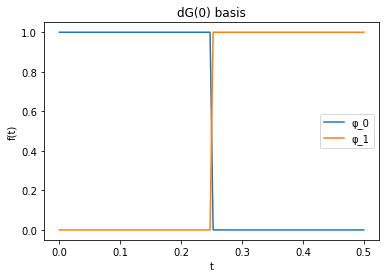

In [4]:
φ_0 = []
for n in range(num_elements):
    φ_0.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       (1 + 0*Id(t), True),
    ))

plot_basis(basis=φ_0, title="dG(0) basis")

### $dG-Q^1$

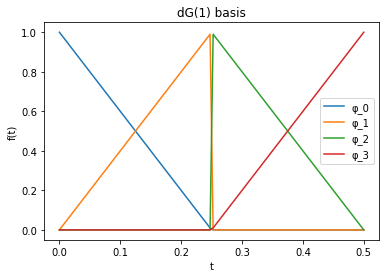

In [5]:
φ_1 = []
for n in range(num_elements):
    φ_1.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       (1-(t-n*k)/k, True),
    ))

    φ_1.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       ((t-n*k)/k, True),
    ))

plot_basis(basis=φ_1, title="dG(1) basis")

### $dG-Q^2$

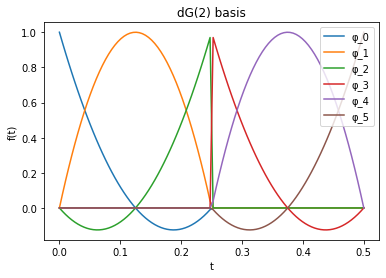

In [6]:
φ_2 = []
for n in range(num_elements):
    φ_2.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       ((2/k**2)*((t-n*k)-k/2)*((t-n*k)-k), True),
    ))

    φ_2.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       (-(4/k**2)*(t-n*k)*((t-n*k)-k), True),
    ))
    
    φ_2.append(Piecewise(
       (0, t < n*k),
       (0, t > (n+1)*k),
       ((2/k**2)*(t-n*k)*((t-n*k)-k/2), True),
    ))

plot_basis(basis=φ_2, title="dG(2) basis")

In [7]:
# dictionary of basis functions for dG(r)
φ = {0: φ_0, 1: φ_1, 2: φ_2}

## Problem statement and Galerkin discretization

We consider the model problem
$$
\partial_t u(t) - λ u(t) = 0 \qquad \forall t \in [0,T],
$$
### One temporal element
Using the Galerkin ansatz $u(t) = \sum_{i = 0}^N U_i \varphi_i(t)$ with $\varphi_i \in V$ and test functions $\varphi \in V$, we solve the weak formulation
$$
(\partial_t u, \varphi) - λ(u, \varphi) + u(0) \cdot \varphi(0) = u^0 \cdot \varphi(0) \qquad \forall \varphi \in V,
$$
where $(f,g) := \int_0^T fg\ \mathrm{d}t$ denotes the $L^2$-inner product in time and the initial condition is directly included in the weak formulation.
This can be rewritten as the linear equation system
$$
\begin{bmatrix}
  (\partial_t \varphi_0, \varphi_0) - λ(\varphi_0, \varphi_0) + 1 & (\partial_t \varphi_1, \varphi_0) - λ(\varphi_1, \varphi_0) & \dots & (\partial_t \varphi_N, \varphi_0) - λ(\varphi_N, \varphi_0) \\
  (\partial_t \varphi_0, \varphi_1) - λ(\varphi_0, \varphi_1) & (\partial_t \varphi_1, \varphi_1) - λ(\varphi_1, \varphi_1) & \dots & (\partial_t \varphi_N, \varphi_1) - λ(\varphi_N, \varphi_1) \\
  \vdots & \vdots & \ddots & \vdots \\
  (\partial_t \varphi_0, \varphi_N) - λ(\varphi_0, \varphi_N) & (\partial_t \varphi_1, \varphi_N) - λ(\varphi_1, \varphi_N) & \dots & (\partial_t \varphi_N, \varphi_N) - λ(\varphi_N, \varphi_N)
\end{bmatrix}
\begin{bmatrix}
U_0 \\
U_1 \\
\vdots \\
U_N
\end{bmatrix}
= \begin{bmatrix}
U^0\\
0\\
\vdots \\
0
\end{bmatrix},
$$
where we used that $\varphi_0(0) = 1$ and $\varphi_j(0) = 0$ for $j > 0$.
### Multiple temporal elements
We can easily extend this also to Galerkin formulation for multiple temporal elements, by adding the jump terms between the temporal elements. We define the the limits of $f$ at time $t_m$ from above and from below for a function $f$ as

$$
f_m^\pm := \lim_{\epsilon \searrow 0} f(t_m \pm \epsilon),
$$

and the jump of the function value of $f$ at time $t_m$ as

$$
[f]_m := f_m^+ - f_m^-.
$$

Let $\mathcal{T}_k := \{ I_m := (t_{m-1}, t_m) \mid 1 \leq m \leq M \}$ be a partitioning of time, i.e. $ \bar{I} = [0,T] = \bigcup_{m = 1}^M \bar{I}_m $. Then we have $M$ temporal elements and need to add jump terms when going from $I_1$ to $I_2$, from $I_2$ to $I_3$, etc.
The weak formulation for multiple temporal elements thus reads:
$$
\sum_{m = 1}^M(\partial_t u, \varphi)_{I_m} - λ(u, \varphi)_{I_m} + \sum_{m=1}^{M-1}[u]_m \cdot \varphi_m^+ + u(0) \cdot \varphi_0^+ = u_0 \cdot \varphi_0^+ \qquad \forall \varphi \in V.
$$
NOTE: We can also include the initial condition in the jump terms by using $u_0^+ = u(0)$ and $u_0^- = u^0$. Then we have
$$
\sum_{m = 1}^M(\partial_t u, \varphi)_{I_m} - λ(u, \varphi)_{I_m} + \sum_{m=0}^{M-1}[u]_m \cdot \varphi_m^+ = 0\qquad \forall \varphi \in V
$$
or equivalently
$$
\sum_{m = 1}^M(\partial_t u, \varphi)_{I_m} - λ(u, \varphi)_{I_m} + [u]_{m-1} \cdot \varphi_{m-1}^+ = 0\qquad \forall \varphi \in V.
$$
We can rewrite this again as a linear equation system, which we examplarily show for 2 temporal elements and dG(1) in time:
$$
\begin{bmatrix}
  (\partial_t \varphi_0, \varphi_0) - λ(\varphi_0, \varphi_0) + 1 & (\partial_t \varphi_1, \varphi_0) - λ(\varphi_1, \varphi_0) & 0 & 0 \\
  (\partial_t \varphi_0, \varphi_1) - λ(\varphi_0, \varphi_1) & (\partial_t \varphi_1, \varphi_1) - λ(\varphi_1, \varphi_1) & 0 & 0 \\
  0 & \color{blue}{-1} & (\partial_t \varphi_2, \varphi_2) - λ(\varphi_2, \varphi_2)\color{blue}{+1} & (\partial_t \varphi_3, \varphi_2) - λ(\varphi_3, \varphi_2) \\
  0 & 0 & (\partial_t \varphi_2, \varphi_3) - λ(\varphi_2, \varphi_3) & (\partial_t \varphi_3, \varphi_3) - λ(\varphi_3, \varphi_3)
\end{bmatrix}
\begin{bmatrix}
U_0 \\
U_1 \\
U_2 \\
U_3
\end{bmatrix}
= \begin{bmatrix}
U^0\\
0\\
0 \\
0
\end{bmatrix}.
$$
In this linear system the jump term between the temporal elements $I_1$ and $I_2$ has been highlighted in blue.

More concretely, we see the linear system after evaluation of the temporal integrals in the code below:

In [8]:
def assemble_matrix(r):
    φ_r = φ[r]
    matrix = []
    for n in range(len(φ_r)):
        matrix.append([0.]*len(φ_r))

    # assemble matrix (for dG(r) there are r+1 DoFs per element)
    for n in range(num_elements):
        for i in range(n*(r+1), (n+1)*(r+1)):
            for j in range(n*(r+1), (n+1)*(r+1)):
                matrix[i][j] = integrate( diff(φ_r[j], t) * φ_r[i] - λ * φ_r[j] * φ_r[i], (t, n*k, (n+1)*k) ).evalf(subs={k: _k, λ: _λ})
    # initial condition
    matrix[0][0] += 1
    # jump terms
    for n in range(1,num_elements):
        matrix[(r+1)*n][(r+1)*n] += 1
        matrix[(r+1)*n][(r+1)*n-1] -= 1
    return matrix

r = 1
matrix = assemble_matrix(r=r)

# print linear system
print(f"For T = {_T}, λ = {_λ} and k = {_k} we get the linear system:")
latex_row = lambda matrix, row: " & ".join([latex(round(entry,6)) for entry in matrix[row]])
latex_matrix = r"\begin{pmatrix}" + r"\\".join([latex_row(matrix,i) for i in range(len(φ[r]))]) + r"\end{pmatrix}"
display(Math(latex_matrix + r"\begin{pmatrix}" + r"\\".join([f"U_{i}" for i in range(len(φ[r]))]) + r"\end{pmatrix} = \begin{pmatrix} U^0 \\ " + r"\\".join(["0" for i in range(1,len(φ[r]))]) + "\end{pmatrix}"))

For T = 0.5, λ = 1.0 and k = 0.25 we get the linear system:


<IPython.core.display.Math object>

More generally, assembling the matrix for dG(1) with two temporal elements analytically similar to Appendix A.1 in [FiRoWiChFa2023](https://arxiv.org/pdf/2304.01140.pdf) for arbitrary values of $\lambda$ and $k$, and with $T = 2k$, we get the linear system

$$
\begin{bmatrix}
  \frac{1}{2} - λ\frac{k}{3}& \frac{1}{2} - λ\frac{k}{6} & 0 & 0 \\
  -\frac{1}{2} - λ\frac{k}{6}& \frac{1}{2} - λ\frac{k}{3} & 0 & 0 \\
  0 & -1 & \frac{1}{2} - λ\frac{k}{3}& \frac{1}{2} - λ\frac{k}{6} \\
  0 & 0 & -\frac{1}{2} - λ\frac{k}{6}& \frac{1}{2} - λ\frac{k}{3}
\end{bmatrix}
\begin{bmatrix}
U_0 \\
U_1 \\
U_2 \\
U_3
\end{bmatrix}
= \begin{bmatrix}
U^0\\
0\\
0 \\
0
\end{bmatrix}.
$$
The proof of this is a straightforward calculation and is left as an exercise to the reader.

## Solve the ODE problem with dG(r) in time

Now that we know what the linear system looks like, we have all the tools to solve the model problem $\partial_t u - \lambda u = 0$. For this we use the initial condition $u(0) = 1$, which means that the analytical solution is $u(t) = \exp(\lambda t)$. We further choose $\lambda = 1$.

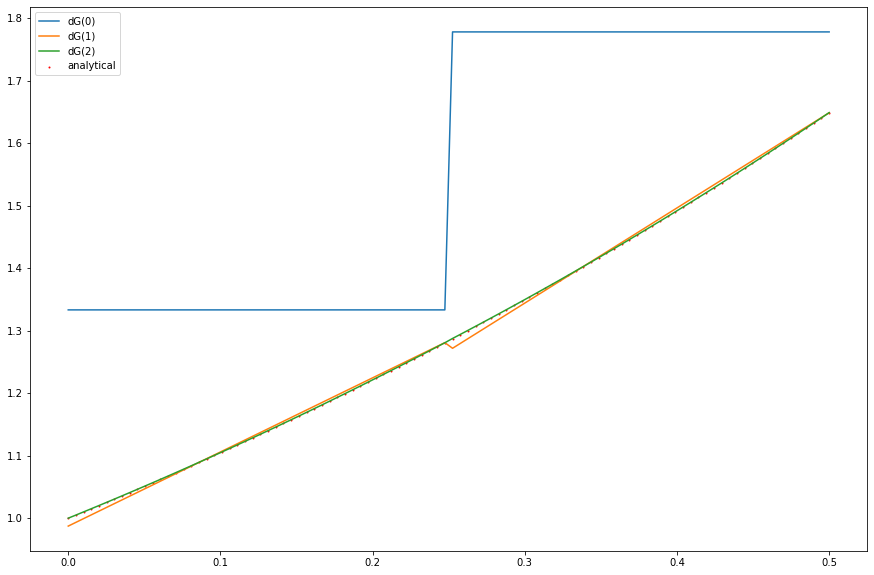

In [9]:
solution = {}

# solve dG(r) problems
for r in range(3):
    # assemble system matrix for dG(r)
    matrix = np.array(assemble_matrix(r=r))
    # assemble right hand side
    rhs = np.zeros((matrix.shape[0],))
    rhs[0] = 1.
    # solve linear system
    solution[r] = np.linalg.solve(matrix.astype('float64'), rhs)

# plot dG solutions and compare it with the analytical solution
plt.figure(figsize=(15,10))
for r in range(3):
    plt.plot(_t, get_basis_lincomb(φ[r], solution[r]), label=f"dG({r})")
plt.scatter(_t, np.exp(_t), label="analytical", s=1, color="red")
plt.legend()
plt.show()